<a href="https://colab.research.google.com/github/egorssed/VAE_on_HST_galaxies/blob/main/Disentangled_BCE_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare the data

In [2]:
from sklearn.model_selection import train_test_split

def normalize_image(images):
    #Normalize image to [0,1]
    for i in range(len(images)):
        images[i]=images[i]-images[i].min()
        images[i]=images[i]/images[i].max()
    return images

galaxy_images=np.load('/content/drive/My Drive/AstroLensing/DataSet/Filtered_Data/Images_filtered.npy')
df=pd.read_csv('/content/drive/My Drive/AstroLensing/DataSet/Filtered_Data/Dataset_labels_filtered.csv',index_col=0)
gal_dataset_images=np.reshape(normalize_image(galaxy_images), (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1))
Features=['Sersic_HLR', 'Sersic_n', 'Sersic_q','Sersic_phi']
Features_number=len(Features)
Features_means=df[Features].mean(axis=0)
Features_stds=df[Features].std(axis=0)

#Extract test dataset
x_train, x_test, y_train, y_test = train_test_split(gal_dataset_images.astype('float32'), df[Features].astype('float32'), test_size=512)
#Extract train and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1248,train_size=20736)

image_size=x_train.shape[1]
batch_size = 32
latent_dim = 64
start_lr = 1e-6

In [3]:
def make_labeled_images(x,labels):
  res=np.zeros((len(x),x.shape[1]+1,x.shape[2],1))
  res[:,:-1,:,:]=x
  res[:,-1,:Features_number,0]=(labels-Features_means)/Features_stds
  return res.astype('float32')

x_train_labeled=make_labeled_images(x_train,y_train)
x_test_labeled=make_labeled_images(x_test,y_test)
x_val_labeled=make_labeled_images(x_val,y_val)

### VAE 

#### libraries

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda,Conv2D,Conv2DTranspose,LeakyReLU,ReLU
from keras.initializers import Constant
from keras.models import Model
from keras.optimizers import Adam
from keras import initializers

#### encoder

In [ ]:
def encoder_Article(input_img):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Conv2D(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(input_img)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=512, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=4096, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    
    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim,)(x)
    z_log_var = Dense(latent_dim, )(x)

    return z_mean,z_log_var

#### decoder

In [ ]:
def decoder_Article(z):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Reshape(target_shape=(1, 1, 64))(z)
    
    x = Conv2DTranspose(filters=512, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    #Xavier intialization for differentiable functions activated layers
    Xavierinitializer=initializers.GlorotNormal()
    decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',
                        activation='sigmoid',use_bias=False,kernel_initializer=Xavierinitializer)(x)
  

    return decoded

#### vae class

In [ ]:
import keras.backend as K
def tensor_values(x):
  return K.eval(x)

#Reparametrization trick
def reparameterize(args):
    mean,logvar=args
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar/2) + mean


#Latent space z[0] is meant to represent (Feature[0]-Features_mean[0])/Features_std[0]
def restore_features_from_z(z):
    features=z[:,:Features_number]
    features*=Features_stds
    features+=Features_means
    return features

In [ ]:
def create_vae():
    models = {}

    input_img_labeled=Input(batch_shape=(batch_size, image_size+1, image_size, 1))
    image=Lambda(lambda x: x[:,:-1,:,:])(input_img_labeled)
    models['split_image']=Model(input_img_labeled,image,name='Split_image')
    
    # Энкодер
    input_img = Input(batch_shape=(batch_size, image_size, image_size, 1))

    z_mean, z_log_var=encoder_Article(input_img)

    #Reparametrization
    l=Lambda(reparameterize, output_shape=(latent_dim,))([z_mean, z_log_var])

    #Features
    f=Lambda(restore_features_from_z,output_shape=(Features_number,))(z_mean)

    models["encoder"]  = Model(input_img, l, name='Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name='Enc_z_mean')
    models["z_log_varer"] = Model(input_img, z_log_var, name='Enc_z_log_var')
    # Декодер
    z = Input(shape=(latent_dim, ))
    
    decoded=decoder_Article(z)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")
    models['features']=Model(input_img,f,name='Features_predictor')

    models['vae_labeled']=Model(input_img_labeled, models["decoder"](models["encoder"](models['split_image'](input_img_labeled))), name="VAE_Labeled")

    return models

### Loss and compilation

#### Custom Loss

In [ ]:
beta_KL=10**-2
alpha_Features=1

In [ ]:
def custom_loss(x_labeled,decoded):
  #Loss function
  reconstruction_loss=tf.keras.losses.binary_crossentropy
  features_loss=tf.keras.losses.MSE

  #Reconstruction quality
  img=x_labeled[:,:-1,:,:]
  flattened_x=K.reshape(img,shape=(batch_size,image_size*image_size))
  flattened_decoded=K.reshape(decoded,shape=(batch_size,image_size*image_size))
  Log_loss=image_size*image_size*reconstruction_loss(flattened_x,flattened_decoded)

  #Latent space N(0,1) distribution
  mean = models['z_meaner'](img)
  logvar=models['z_log_varer'](img)

  KL_loss=0.5 * K.sum(1 + logvar - K.square(mean) - K.exp(logvar), axis=-1)

  #Features prediction
  labels=x_labeled[:,-1,:,0]
  Features_loss=image_size*features_loss(labels[:,:Features_number],mean[:,:Features_number])

  #Choice of loss function
  Beta_Loss=(Log_loss-beta_KL*KL_loss+alpha_Features*Features_loss)/image_size/image_size

  return Beta_Loss

#### initialization of model

In [ ]:
with tf.device('/device:GPU:0'):
  models= create_vae()
  vae = models["vae"]
  vae_labeled=models['vae_labeled']
  vae_labeled.compile(optimizer=Adam(learning_rate=start_lr, beta_1=0.5, beta_2=0.999), loss=custom_loss)

### Load model

In [ ]:
Checkpoint_to_load=50
Folder='/content/drive/My Drive/AstroLensing/Disentangled_VAE/BCE_reconstruction+64_MSE_features_KL_all/'
vae_labeled.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))

### Callbacks

In [ ]:
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard
import pandas as pd

def plot_digits(*args, invert_colors=False,show=True):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((image_size * len(args), image_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * image_size: (j + 1) * image_size,
                   i * image_size: (i + 1) * image_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if show:
      plt.show()



# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

def Show_latent_distr():
  fig,ax=plt.subplots(1,4,figsize=(15,4))

  z_mean=tensor_values(models['z_meaner'].predict(x_test))
  z_log_var=tensor_values(models['z_log_varer'].predict(x_test))

  ax[0].hist(np.mean(z_mean,axis=0),alpha=0.5,label='mean')
  ax[0].hist(np.mean(z_log_var,axis=0),alpha=0.5,label='log_var')
  ax[0].set_title('Latent space distribution')
  ax[0].legend()

  reconstruction_loss=tf.keras.losses.binary_crossentropy
  features_loss=tf.keras.losses.MSE

  #reconstruction quality
  flattened_x=K.reshape(x_test,shape=(len(x_test),image_size*image_size))
  flattened_decoded=K.reshape(vae.predict(x_test),shape=(len(x_test),image_size*image_size))
  Log_loss=image_size*image_size*reconstruction_loss(flattened_x,flattened_decoded)

  KL_loss=0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

  #Features prediction
  labels=x_test_labeled[:,-1,:,0]
  Features_loss=image_size*features_loss(labels[:,:Features_number],z_mean[:,:Features_number])

  df=pd.DataFrame()
  df['KL_loss']=KL_loss
  df['Reconstruction_loss']=Log_loss
  df['Features_loss']=Features_loss
  sns.barplot(ax=ax[1],data=df[['Reconstruction_loss']])
  sns.barplot(ax=ax[2],data=df[['KL_loss']])
  sns.barplot(ax=ax[3],data=df[['Features_loss']])
  plt.tight_layout()
  plt.show()

def learning_curve(filename,start_epoch=0,stop_epoch=1000,show=True):
  logs_file=open(filename)
  lines=logs_file.readlines()
  logs_file.close()


  loss=np.array([])
  val_loss=np.array([])
  for line in lines:
    note=ast.literal_eval(line)
    loss=np.append(loss,[note['loss']])
    val_loss=np.append(val_loss,[note['val_loss']])

  start_index=start_epoch//10
  stop_index=np.minimum(len(loss),stop_epoch//10+1)
  plt.plot(10*np.arange(start_index,stop_index),loss[start_index:stop_index],label='Train')
  plt.plot(10*np.arange(start_index,stop_index),val_loss[start_index:stop_index],label='Validation')
  plt.ylabel('Loss')
  plt.xlabel('epoch number')
  plt.title('Learning curve')
  plt.legend()
  if show:
      plt.show()

def on_epoch_end(epoch, logs):
  #Every 10 epoch do the following
    if np.mod(epoch,10)==0:
        clear_output()
        
        #plot 10 original and reconstructed galaxies from test dataset
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        #Also take a look on how latent space variables are distributed
        Show_latent_distr()

        #Make a checkpoint of model weights on Google drive
        Model_folder=Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load+epoch)
        vae_labeled.save_weights(Model_folder)

        #Write loss logs
        file_object = open(Folder+'logs.txt', 'a')
        file_object.write(str(logs))
        file_object.write('\n')
        file_object.close()

        learning_curve(Folder+'logs.txt',np.maximum(Checkpoint_to_load+epoch-200,0),Checkpoint_to_load+epoch)

        

        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
lr_red = ReduceLROnPlateau(factor=0.1, patience=30, min_lr=1e-8,verbose=1)
tb     = TensorBoard(log_dir='./logs')

### Training

In [ ]:
_ = vae_labeled.fit(x_train_labeled, x_train_labeled, shuffle=True, epochs=900,
        batch_size=batch_size,
        validation_data=(x_val_labeled, x_val_labeled),
        callbacks=[pltfig,lr_red],
        verbose=1)

Epoch 1/900
124/648 [====>.........................] - ETA: 1:35 - loss: 0.2865

# Examine results

## Functions

In [ ]:
import ast
from tqdm import tqdm
import seaborn as sns
import copy

images_for_test=gal_dataset_images[:-19]

def learning_curve(filename,start_epoch=0,stop_epoch=1000):
  logs_file=open(filename)
  lines=logs_file.readlines()
  logs_file.close()


  loss=np.array([])
  val_loss=np.array([])
  for line in lines:
    note=ast.literal_eval(line)
    loss=np.append(loss,[note['loss']])
    val_loss=np.append(val_loss,[note['val_loss']])

  start_index=start_epoch//10
  stop_index=np.minimum(len(loss),stop_epoch//10)
  plt.plot(10*np.arange(start_index,stop_index),loss[start_index:stop_index],label='loss')
  plt.plot(10*np.arange(start_index,stop_index),val_loss[start_index:stop_index],label='val_loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch number')
  plt.legend()

def latent_distribution(variable='mean'):
  fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
  axs_flat = axs.flatten()  
  for i in range(z_means.shape[1]):
    if variable=='mean':
      axs_flat[i].hist(z_means[:,i], bins=50)
    else:
      axs_flat[i].hist(z_log_vars[:,i], bins=50)
    axs_flat[i].set_title('Z {}'.format(i))
    axs_flat[i].get_yaxis().set_visible(False)
  fig.tight_layout()

def latent_relation_of_variances(sorted=False):
    if sorted:
      g=sns.barplot(x=np.linspace(0,64,64),y=np.sort(ratio)[::-1])
    else:
      g=sns.barplot(x=np.linspace(0,64,64),y=ratio)
    #g.xaxis.set_visible(False)
    plt.hlines(1,0,63,label=r'$\mu_{std}=\sigma_{mean}$')
    plt.legend()
    plt.xticks([])
    plt.xlabel('Latent variable')
    plt.ylabel('Ratio')
    plt.title(r'$\mu_{std}/\sigma_{mean}$')

def galaxy_properties_from_latent_variables(number_of_z_to_consider=64,sorted=True):
  latent_average=z_means.mean(axis=0)
  if sorted:
    variables_to_consider=np.argsort(ratio)[::-1][:number_of_z_to_consider]
  else:
    variables_to_consider=range(0,number_of_z_to_consider)
  variances_to_consider=np.exp(z_log_vars.std(axis=0)[variables_to_consider]/2)
  z_to_consider=np.zeros((number_of_z_to_consider,7,64))
  #i - number of variable to change
  for i in range(number_of_z_to_consider):
    #j - number of sigmas to add to it
    for j in range(7):
      #Assign everything to be like average galaxy
      z_to_consider[i,j,:]=latent_average
      #Vary one of the variables to get mu+-(0,1,2,3)*sigma
      z_to_consider[i,j,variables_to_consider[i]]+=(j-3)*variances_to_consider[i]
  images_to_consider=models['decoder'].predict(z_to_consider.reshape((number_of_z_to_consider*7,64)))
  #plot_digits(images_to_consider[:7],images_to_consider[7:14])
  for i in range(number_of_z_to_consider):
    plot_digits(images_to_consider[i*7:(i+1)*7],show=False)

def rotational_invariance_and_denoising():
  imgs_turned=copy.deepcopy(imgs)
  imgs_turned[0]=imgs[0,::-1,:,:]
  imgs_turned[1]=imgs[0]
  imgs_turned[2:5]=[imgs[0]+np.random.normal(0,1/i,imgs[0].shape) for i in range(60,10,-20)]
  decoded_turned= vae.predict(imgs_turned, batch_size=batch_size)
  plot_digits(imgs_turned[:5],decoded_turned[:5],show=False)

def loss_functions_distribution(KL_type='Original'):
  loss_func=tf.keras.losses.binary_crossentropy

  #reconstruction quality
  flattened_x=K.reshape(images_for_test,shape=(len(images_for_test),image_size*image_size))
  flattened_decoded=K.reshape(decoded,shape=(len(images_for_test),image_size*image_size))
  Log_loss=image_size*image_size*loss_func(flattened_x,flattened_decoded)

  KL_loss=0.5 * K.sum(1 + z_log_vars - K.square(z_means) - K.exp(z_log_vars), axis=-1)

  #Choice of loss function
  Beta_Loss=(Log_loss-beta_vae*KL_loss)/image_size/image_size
  
  free_bits_tensor=K.constant(free_bits*np.ones(KL_loss.shape[0]))
  Flow_Loss=(Log_loss-K.maximum(-free_bits_tensor,KL_loss))/image_size/image_size

  if KL_type=='Original':
    KL_to_show=KL_loss/image_size/image_size
  elif KL_type=='Beta':
    KL_to_show=beta_vae*KL_loss/image_size/image_size
  elif KL_type=='Flow':
    KL_to_show=(KL_loss)/image_size/image_size
    print('Flow_KL=max({:.5f},KL_loss)'.format(-free_bits/image_size/image_size))
  else:
    print('wrong type')
    return


  fig,ax=plt.subplots(1,2)

  ax[0].hist(Log_loss/image_size/image_size,bins=100)
  ax[0].set_title('Binary crossentropy')
  
  ax[1].hist(KL_to_show,bins=100)
  ax[1].set_title(KL_type+' KL divergence')

  plt.tight_layout()

def present_reconstruction(resid=False):
    images_for_reconst=np.zeros((32,64,64,1))

    #Images selection
    images_for_reconst[0]=imgs[0]
    images_for_reconst[1]=imgs[13]
    images_for_reconst[2]=imgs[28]
    images_for_reconst[3]=imgs[20]
    images_for_reconst[4]=imgs[23]
    images_for_reconst[5]=imgs[27]
    images_for_reconst[6]=imgs[1]
    images_for_reconst[7]=imgs[22]
    images_for_reconst[8]=imgs[30]
    images_for_reconst[9]=imgs[17]

    decoded_to_reconstruct=vae.predict(images_for_reconst, batch_size=batch_size)
    if resid:
      residuals=decoded_to_reconstruct-images_for_reconst
      plot_digits(images_for_reconst[:10],decoded_to_reconstruct[:10],residuals[:10],show=False)
      plt.colorbar()
    else:
      plot_digits(images_for_reconst[:10],decoded_to_reconstruct[:10],show=False)

# Disentangled VAE examination

## BCE loss, sigmoid act, [0,1] normalized images

In [ ]:
Checkpoint_to_load=320
Folder='/content/drive/My Drive/AstroLensing/Disentangled_VAE/BCE_reconstruction+BetaKL_features'
vae_labeled.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))

images_for_test=gal_dataset_images[:-19]

z_means=models['z_meaner'].predict(images_for_test)
z_log_vars=models['z_log_varer'].predict(images_for_test)
decoded=models['vae'].predict(images_for_test)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

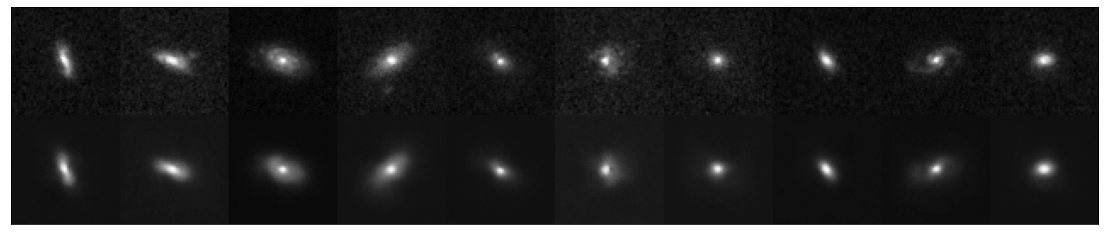

In [ ]:
present_reconstruction()

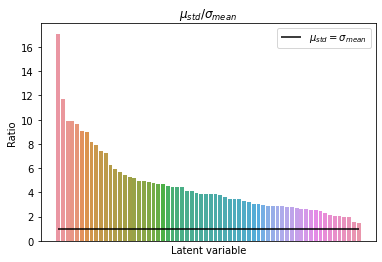

In [ ]:
latent_relation_of_variances(sorted=True)

In [ ]:
from sklearn.metrics import r2_score
y_pred=models['features'](x_test)
for i,feature in enumerate(Features):
  print(feature+' {:.2f}'.format(np.abs((y_test.iloc[:,i]-y_pred[:,i].numpy())/y_test.iloc[:,i]).mean()))

Sersic_HLR 0.36
Sersic_n 1.46
Sersic_q 0.50
Sersic_phi 57.79


Text(0.5, 1.0, 'Spearman rank correlation')

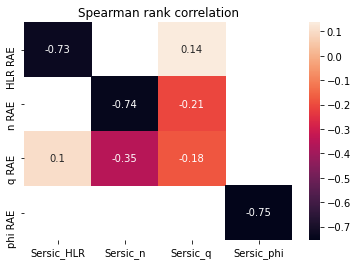

In [ ]:
from scipy.stats import spearmanr
import seaborn as sns
corr_matrix=np.zeros((4,4))
for i in range(4):
  for j in range(4):
      spearman=spearmanr(np.abs((y_pred[:,i] - y_test.iloc[:,i])/y_test.iloc[:,i]),y_test.iloc[:,j])
      corr_matrix[i,j]=spearman.correlation if spearman.pvalue < 0.05 else np.nan

corr_df=pd.DataFrame(data=corr_matrix,index=[x[7:]+' RAE' for x in Features],columns=Features)
sns.heatmap(corr_df,annot=True)
plt.title('Spearman rank correlation')

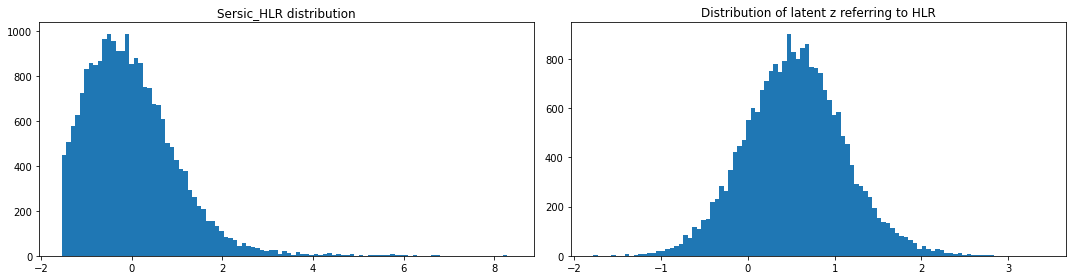

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

ax[0].hist((df[Features[0]]-Features_means[0])/Features_stds[0],bins=100)
ax[0].set_title('Sersic_HLR distribution')

ax[1].hist(z_means[:,0],bins=100)
ax[1].set_title('Distribution of latent z referring to HLR')

plt.tight_layout()
plt.show()

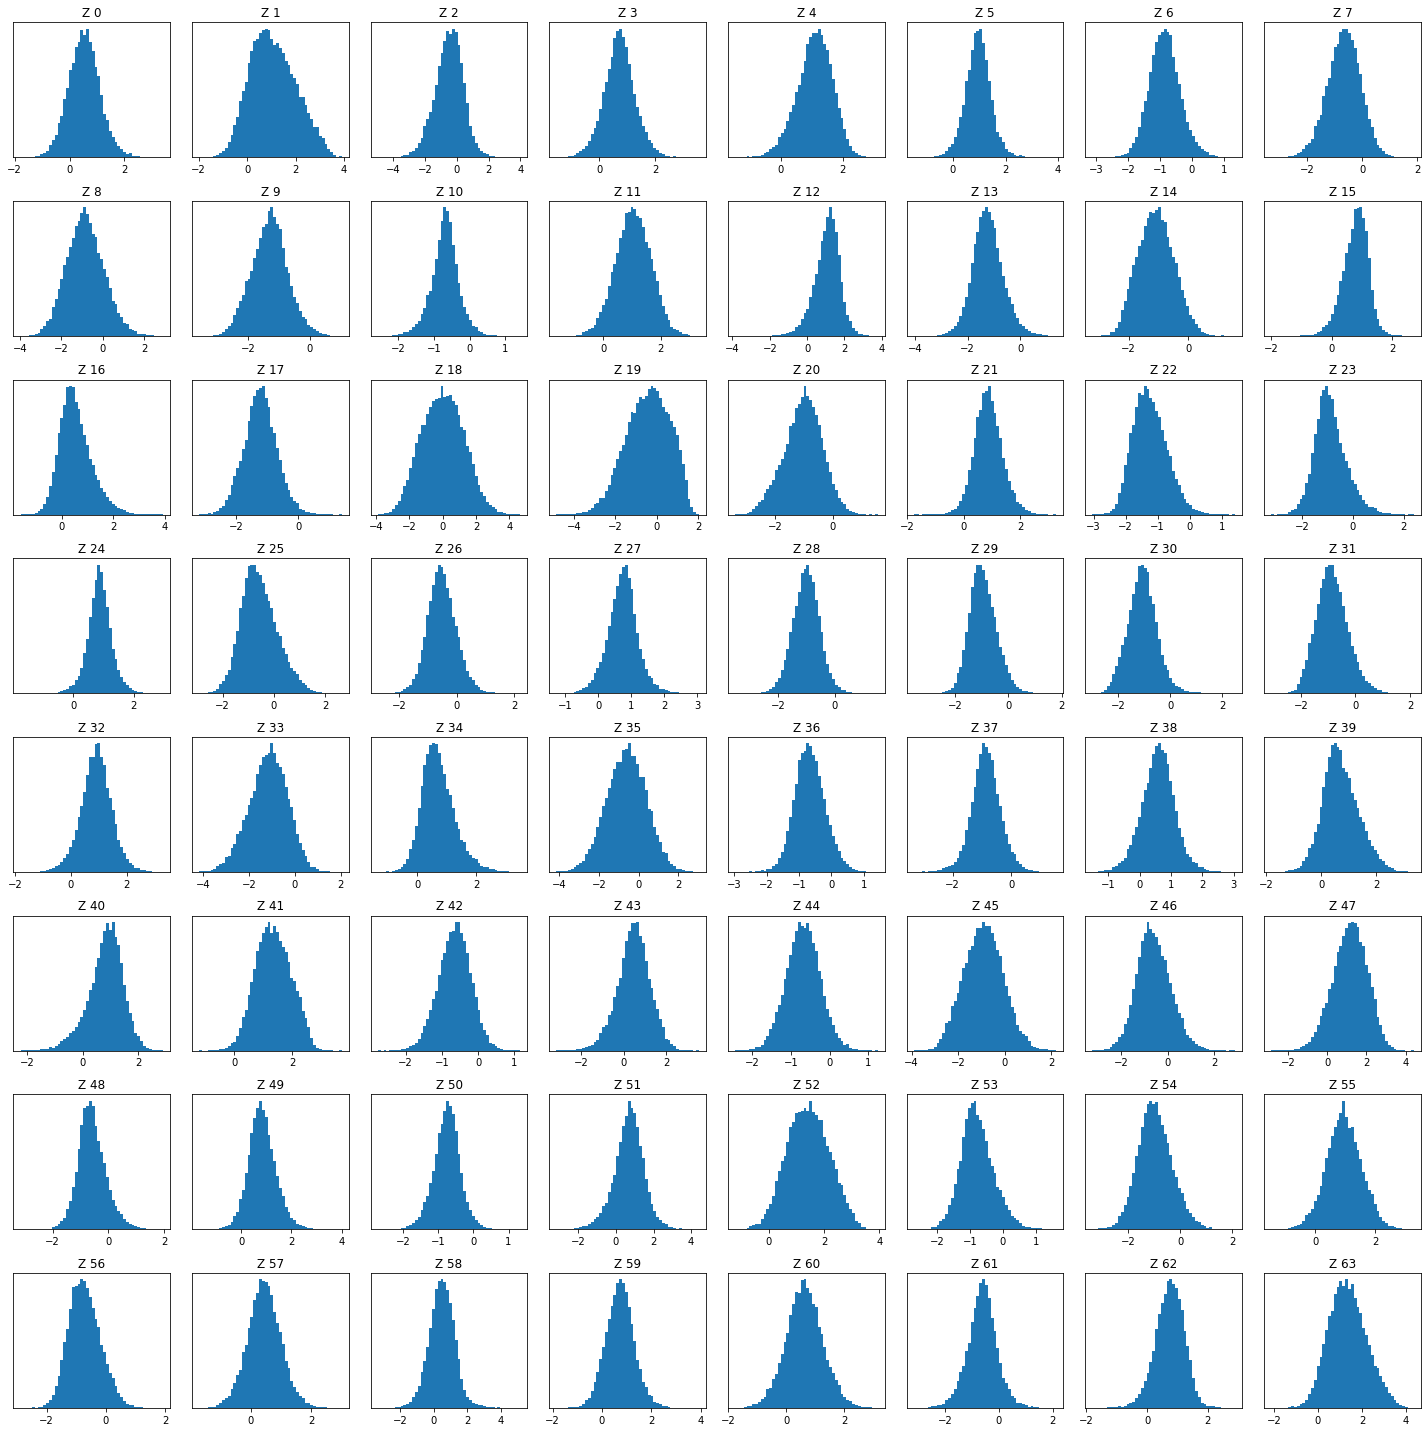

In [ ]:
latent_distribution()

## BCE_reconstruction+ MSE_Features+KL_rest

In [ ]:
Checkpoint_to_load=30
Folder='/content/drive/My Drive/AstroLensing/Disentangled_VAE/BCE_reconstruction+64_MSE_features_KL_rest'
vae_labeled.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))

z_means=models['z_meaner'].predict(images_for_test)
z_log_vars=models['z_log_varer'].predict(images_for_test)
decoded=models['vae'].predict(images_for_test)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

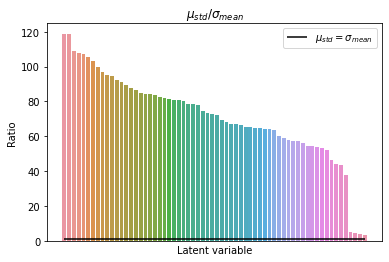

In [ ]:
latent_relation_of_variances(sorted=True)

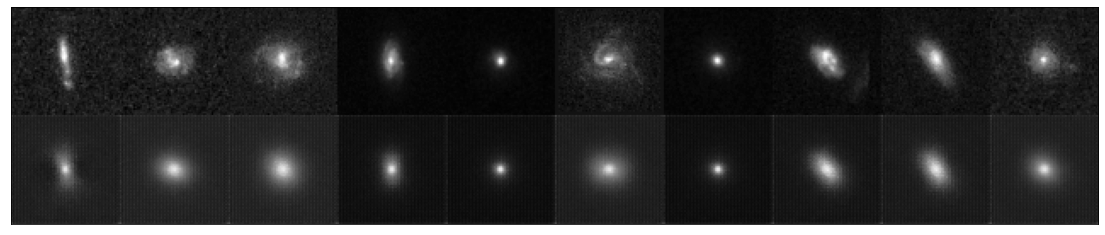

In [ ]:
present_reconstruction()

## BCE_reconstruction+ MSE_Features+KL_all

In [ ]:
Checkpoint_to_load=50
Folder='/content/drive/My Drive/AstroLensing/Disentangled_VAE/BCE_reconstruction+64_MSE_features_KL_all/'
vae_labeled.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))

z_means=models['z_meaner'].predict(images_for_test)
z_log_vars=models['z_log_varer'].predict(images_for_test)
decoded=models['vae'].predict(images_for_test)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

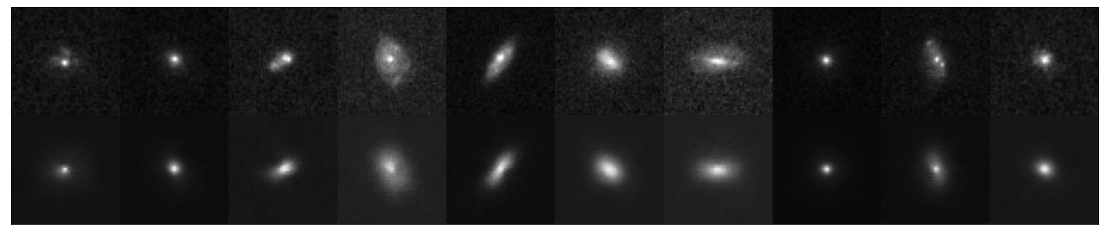

In [ ]:
present_reconstruction()

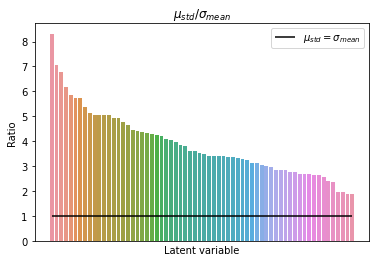

In [ ]:
latent_relation_of_variances(sorted=True)

In [ ]:
y_pred=models['features'](x_test)
for i,feature in enumerate(Features):
  print(feature+' {:.2f}'.format(np.abs((y_test.iloc[:,i]-y_pred[:,i].numpy())/y_test.iloc[:,i]).mean()))

Sersic_HLR 0.07
Sersic_n 0.14
Sersic_q 0.07
Sersic_phi 3.32


In [ ]:
#latent_distribution()

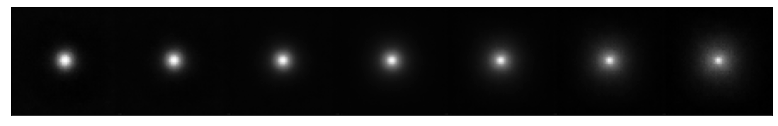

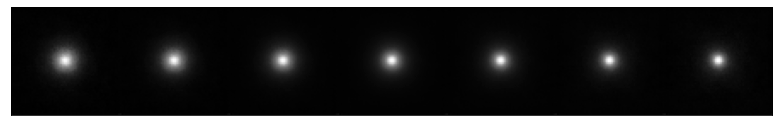

In [ ]:
galaxy_properties_from_latent_variables(2,False)